Using device: cpu

Testing Configuration 1: [64, 64] neurons, tanh activation
[Before Training Config 1] RAM usage: 717.35 MB
Epoch: 0, Avg Loss: 0.7457
Epoch: 100, Avg Loss: 0.4642
Early stopping at epoch 169
Config 1 took 14.57 minutes.
[After Training Config 1] RAM usage: 209.92 MB
Training Accuracy: 0.8544
Test Accuracy: 0.8524
Total Parameters: 8135, Estimated RAM: 32540 bytes

Testing Configuration 2: [64, 64] neurons, relu activation
[Before Training Config 2] RAM usage: 522.20 MB
Epoch: 0, Avg Loss: 1.3224
Epoch: 100, Avg Loss: 0.4911
Epoch: 200, Avg Loss: 0.4612
Epoch: 300, Avg Loss: 0.4477
Early stopping at epoch 302
Config 2 took 39.53 minutes.
[After Training Config 2] RAM usage: 209.33 MB
Training Accuracy: 0.8477
Test Accuracy: 0.8450
Total Parameters: 8135, Estimated RAM: 32540 bytes

Testing Configuration 3: [128, 128, 128, 128] neurons, tanh activation
[Before Training Config 3] RAM usage: 520.83 MB
Epoch: 0, Avg Loss: 0.6902
Epoch: 100, Avg Loss: 0.3550
Early stopping

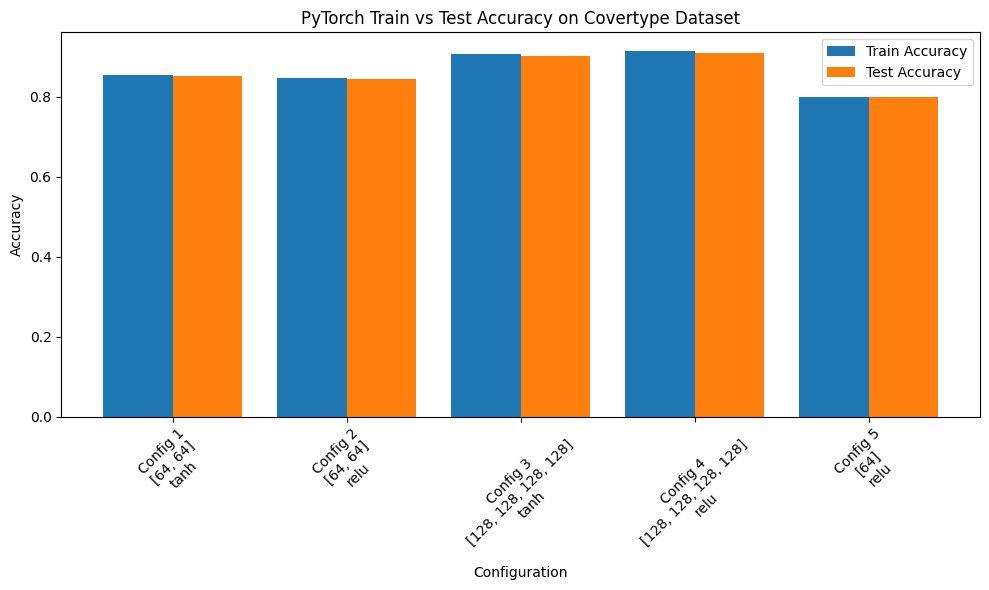

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.datasets import fetch_covtype
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import matplotlib.pyplot as plt
import os
import psutil
import time

def print_memory_usage(label=""):
    process = psutil.Process(os.getpid())
    mem_mb = process.memory_info().rss / 1024 / 1024  
    print(f"[{label}] RAM usage: {mem_mb:.2f} MB")

torch.manual_seed(0)
np.random.seed(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

data = fetch_covtype()
X, y = data.data, data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = torch.FloatTensor(X_train).to(device)
X_test = torch.FloatTensor(X_test).to(device)
y_train = torch.LongTensor(y_train - 1).to(device)  
y_test = torch.LongTensor(y_test - 1).to(device)

# Neural Network 
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, hidden_activation='tanh', dropout_rate=0.2):
        super(NeuralNetwork, self).__init__()
        layers = []
        prev_size = input_size
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(nn.Tanh() if hidden_activation == 'tanh' else nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            prev_size = hidden_size
        layers.append(nn.Linear(prev_size, output_size))
        self.network = nn.Sequential(*layers)
        
        # Initialize weights
        for layer in self.network:
            if isinstance(layer, nn.Linear):
                if hidden_activation == 'relu':
                    nn.init.kaiming_normal_(layer.weight, nonlinearity='relu')
                else:
                    nn.init.xavier_normal_(layer.weight)
                nn.init.zeros_(layer.bias)
    
    def forward(self, x):
        return self.network(x)

# Training function
def train_model(model, X_train, y_train, X_test, y_test, epochs, batch_size, lr, patience=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    n_batches = len(X_train) // batch_size
    results = {'train_acc': [], 'test_acc': [], 'train_loss': [], 'test_loss': []}
    best_test_loss = float('inf')
    patience_counter = 0

    eval_train_size = 10000
    eval_test_size = 10000
    train_subset_idx = torch.randperm(len(X_train))[:eval_train_size].to(device)
    test_subset_idx = torch.randperm(len(X_test))[:eval_test_size].to(device)

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        indices = torch.randperm(len(X_train)).to(device)
        for i in range(n_batches):
            batch_idx = indices[i * batch_size:(i + 1) * batch_size]
            X_batch, y_batch = X_train[batch_idx], y_train[batch_idx]
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        model.eval()
        with torch.no_grad():
            train_outputs = model(X_train[train_subset_idx])
            train_loss = criterion(train_outputs, y_train[train_subset_idx]).item()
            train_pred = torch.argmax(train_outputs, dim=1)
            train_acc = accuracy_score(y_train[train_subset_idx].cpu().numpy(), train_pred.cpu().numpy())
            test_outputs = model(X_test[test_subset_idx])
            test_loss = criterion(test_outputs, y_test[test_subset_idx]).item()
            test_pred = torch.argmax(test_outputs, dim=1)
            test_acc = accuracy_score(y_test[test_subset_idx].cpu().numpy(), test_pred.cpu().numpy())

        results['train_acc'].append(train_acc)
        results['test_acc'].append(test_acc)
        results['train_loss'].append(train_loss)
        results['test_loss'].append(test_loss)

        if epoch % 100 == 0:
            print(f"Epoch: {epoch}, Avg Loss: {epoch_loss / n_batches:.4f}")

        if test_loss < best_test_loss:
            best_test_loss = test_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch}")
                break

    return results

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def estimate_ram(parameters):
    return parameters * 4  

configs = [
    {'hidden_sizes': [64, 64], 'activation': 'tanh', 'lr': 0.001, 'epochs': 500},
    {'hidden_sizes': [64, 64], 'activation': 'relu', 'lr': 0.0001, 'epochs': 500},
    {'hidden_sizes': [128, 128, 128, 128], 'activation': 'tanh', 'lr': 0.001, 'epochs': 500},
    {'hidden_sizes': [128, 128, 128, 128], 'activation': 'relu', 'lr': 0.0001, 'epochs': 500},
    {'hidden_sizes': [64], 'activation': 'relu', 'lr': 0.0001, 'epochs': 500}
]

# Run experiments
input_size = X_train.shape[1]
output_size = len(np.unique(y))
batch_size = 512
results_summary = []

for idx, config in enumerate(configs, 1):
    print(f"\nTesting Configuration {idx}: {config['hidden_sizes']} neurons, {config['activation']} activation")
    model = NeuralNetwork(input_size, config['hidden_sizes'], output_size, config['activation']).to(device)
    
    print_memory_usage(f"Before Training Config {idx}")
    start_time = time.time()
    
    results = train_model(model, X_train, y_train, X_test, y_test, config['epochs'], batch_size, config['lr'])
    
    end_time = time.time()
    elapsed = (end_time - start_time) / 60
    print(f"Config {idx} took {elapsed:.2f} minutes.")
    print_memory_usage(f"After Training Config {idx}")
    
    model.eval()
    with torch.no_grad():
        train_outputs = model(X_train)
        train_pred = torch.argmax(train_outputs, dim=1).cpu().numpy()
        test_outputs = model(X_test)
        test_pred = torch.argmax(test_outputs, dim=1).cpu().numpy()

    train_acc = accuracy_score(y_train.cpu().numpy(), train_pred)
    test_acc = accuracy_score(y_test.cpu().numpy(), test_pred)
    train_precision = precision_score(y_train.cpu().numpy(), train_pred, average='weighted')
    test_precision = precision_score(y_test.cpu().numpy(), test_pred, average='weighted')
    train_recall = recall_score(y_train.cpu().numpy(), train_pred, average='weighted')
    test_recall = recall_score(y_test.cpu().numpy(), test_pred, average='weighted')
    train_f1 = f1_score(y_train.cpu().numpy(), train_pred, average='weighted')
    test_f1 = f1_score(y_test.cpu().numpy(), test_pred, average='weighted')

    params = count_parameters(model)
    ram = estimate_ram(params)

    print(f"Training Accuracy: {train_acc:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Total Parameters: {params}, Estimated RAM: {ram} bytes")

    results_summary.append({
        'Config': f'Config {idx}',
        'Hidden Sizes': config['hidden_sizes'],
        'Activation': config['activation'],
        'Train Accuracy': train_acc,
        'Test Accuracy': test_acc,
        'Train Precision': train_precision,
        'Test Precision': test_precision,
        'Train Recall': train_recall,
        'Test Recall': test_recall,
        'Train F1': train_f1,
        'Test F1': test_f1,
        'Parameters': params,
        'RAM (bytes)': ram,
        'Time (min)': elapsed
    })

# Save results
df_results = pd.DataFrame(results_summary)
df_results.to_csv('pytorch_covtype_results.csv', index=False)
print("\nResults saved to 'pytorch_covtype_results.csv'")

# Plot results
plt.figure(figsize=(10, 6))
x = np.arange(len(configs))
plt.bar(x - 0.2, [r['Train Accuracy'] for r in results_summary], 0.4, label='Train Accuracy')
plt.bar(x + 0.2, [r['Test Accuracy'] for r in results_summary], 0.4, label='Test Accuracy')
plt.xlabel('Configuration')
plt.ylabel('Accuracy')
plt.title('PyTorch Train vs Test Accuracy on Covertype Dataset')
plt.xticks(x, [f'Config {i+1}\n{r["Hidden Sizes"]}\n{r["Activation"]}' for i, r in enumerate(results_summary)], rotation=45)
plt.legend()
plt.tight_layout()
plt.savefig('pytorch_covtype_accuracy_plot.png')
plt.show()
